# Multiband field photometric calibration

The purpose of this notebook is to experiment with a multiband photometric calibration for fields where this is available

In [2]:
from os import path
from pyDANDIA import metadata, crossmatch, gaia_phot_transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import ODR, Data, Model
from astropy.table import Table, Column
import json

## OGLE-2024-BLG-0034

Photometry is available from gp and ip 1m0 datasets for this event, and the star catalogs have been crossmatched to produce a field crossmatch file.  

In [3]:
# Dataset
target_name = 'OGLE-2024-BLG-0034'
xmatch_file_path = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_field_crossmatch.fits'
gp_metadata_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_gp/pyDANDIA_metadata.fits'
ip_metadata_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_ip/pyDANDIA_metadata.fits'
gp_red_dir = 'OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_gp'
ip_red_dir = 'OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_ip'
gp_lc_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_gp/star_50317_OGLE-2024-BLG-0034_gp_auto.dat'
ip_lc_file = '/Users/rstreet/OMEGAII/Data/OGLE-2024-BLG-0034/data/OGLE-2024-BLG-0034_lsc-domb-1m09-fa04_ip/star_59601_OGLE-2024-BLG-0034_ip_auto.dat'

In [4]:
# Load the crossmatch table for the field
xmatch = crossmatch.CrossMatchTable()
xmatch.load(xmatch_file_path)

However, the stars table in this file only contains calibrated instrumental magnitudes from the respective reference images, rather than the raw measurements. So we can load those from each dataset's original metadata.star_catalog table, and extract the relevant data columns using 
the cross-matched star index for the field.

In [5]:
# Load the metadata for each dataset
gp_metadata = metadata.MetaData()
gp_metadata.load_all_metadata(path.dirname(gp_metadata_file), path.basename(gp_metadata_file))

ip_metadata = metadata.MetaData()
ip_metadata.load_all_metadata(path.dirname(ip_metadata_file), path.basename(ip_metadata_file))

In [6]:
# Calculate Gaia magnitudes and uncertainties
(Gmag, Gmerr) = gaia_phot_transforms.gaia_flux_to_mag(xmatch.stars['phot_g_mean_flux'],
                                                      xmatch.stars['phot_g_mean_flux_error'],
                                                      passband="G")
(BPmag, BPmerr) = gaia_phot_transforms.gaia_flux_to_mag(xmatch.stars['phot_bp_mean_flux'],
                                                    xmatch.stars['phot_bp_mean_flux_error'],
                                                    passband="G_BP")
(RPmag, RPmerr) = gaia_phot_transforms.gaia_flux_to_mag(xmatch.stars['phot_rp_mean_flux'],
                                                    xmatch.stars['phot_rp_mean_flux_error'],
                                                    passband="G_RP")

In [7]:
# Identify stars with valid entries for calibrated photometry in the lsc-domb datasets.  
# This will be used to identify the indices of the valid stars rather than for the photometry
mag_col_gp = 'cal_g_mag_lsc_domb'
mag_col_ip = 'cal_i_mag_lsc_domb'
jdx = np.logical_and(xmatch.stars[mag_col_gp] > 0.0, xmatch.stars[mag_col_ip] > 0.0)
jdx = np.logical_and(jdx, Gmag > 0.0)
jdx = np.logical_and(jdx, BPmag > 0.0)
jdx = np.logical_and(jdx, RPmag > 0.0)
select_stars = np.where(jdx)[0]
print(str(len(select_stars)) + ' stars selected with valid photometry in both passbands and from Gaia DR3')

# Extract the indices of these stars in the respective datasets from the xmatch field index
gp_select_stars = xmatch.field_index[gp_red_dir+'_index'][select_stars] - 1
ip_select_stars = xmatch.field_index[ip_red_dir+'_index'][select_stars] - 1

# Identify the target, OGLE-2024-BLG-0034 in the data arrays
target_field_id = 59601
target_field_idx = target_field_id - 1

tselect = np.where(select_stars == target_field_idx)[0][0]
print('Target index in selected stars array: ' + str(tselect))

69416 stars selected with valid photometry in both passbands and from Gaia DR3
Target index in selected stars array: 32070


Now we can extract the instrumental magnitudes in each band and the Gaia photometry for the corresponding stars

In [8]:
phot = np.zeros((len(gp_select_stars),10))

phot[:,0] = gp_metadata.star_catalog[1]['ref_mag'][gp_select_stars]
phot[:,1] = gp_metadata.star_catalog[1]['ref_mag_error'][gp_select_stars]

phot[:,2] = ip_metadata.star_catalog[1]['ref_mag'][ip_select_stars]
phot[:,3] = ip_metadata.star_catalog[1]['ref_mag_error'][ip_select_stars]

phot[:,4] = Gmag[select_stars]
phot[:,5] = Gmerr[select_stars]
phot[:,6] = BPmag[select_stars]
phot[:,7] = BPmerr[select_stars]
phot[:,8] = RPmag[select_stars]
phot[:,9] = RPmerr[select_stars]

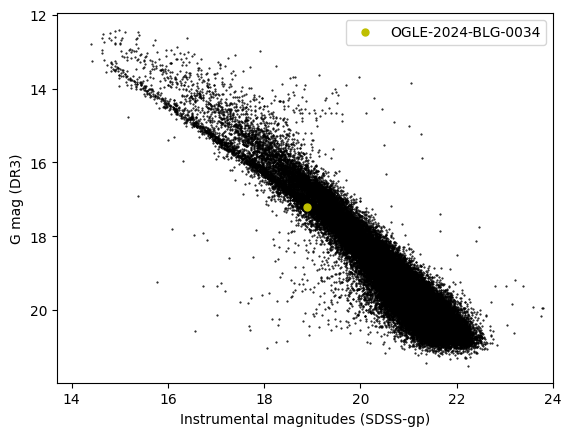

In [9]:
plt.plot(phot[:,0], phot[:,4], 'k.', markersize=1)
[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, 24.0, ymax, ymin])
plt.xlabel('Instrumental magnitudes (SDSS-gp)')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,0], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034')
plt.legend()

plt.show()

There is a 'fringe' of points above the main 'backbone' of data.  An example of one such star is Field index=1450 (Field ID = 1449). From the gp, ip metadata this star is:

In [10]:
star_field_idx = 2273
gp_idx = xmatch.field_index[gp_red_dir+'_index'][star_field_idx] - 1
ip_idx = xmatch.field_index[ip_red_dir+'_index'][star_field_idx] - 1
print('Example star field index = ' + str(star_field_idx) + ' corresponds to gp star index ' + str(gp_idx) + ' and ip star index ' + str(ip_idx))
print('Pixel locations: gp: ' + str(gp_metadata.star_catalog[1]['x'][gp_idx]) + ', ' + str(gp_metadata.star_catalog[1]['y'][gp_idx]))
print('Pixel locations: ip: ' + str(ip_metadata.star_catalog[1]['x'][ip_idx]) + ', ' + str(ip_metadata.star_catalog[1]['y'][ip_idx]))

Example star field index = 2273 corresponds to gp star index 1454 and ip star index 2273
Pixel locations: gp: 3562.6754487753615, 94.68216723081852
Pixel locations: ip: 3557.676085169386, 101.55232767508745


Visually inspecting the reference images for a few examples of stars in this fringe:

1450: Bright (though not saturated), close to edge of frame but not affected by it. 

6302: Moderately bright (not saturated), no issues

2273: Moderately bright (not saturated), no issues

It seems as though there is nothing wrong at the pixel data level, or the PSF fitting for these stars, so it looks like they are a distinct population in colour space, likely due to a combination of intrinsic colour and extinction/reddening.  

So we need to take the colour term into account for an accurate photometric calibration.  This is something the automatic pipeline cannot do since it is designed to reduce data in a single passband. 

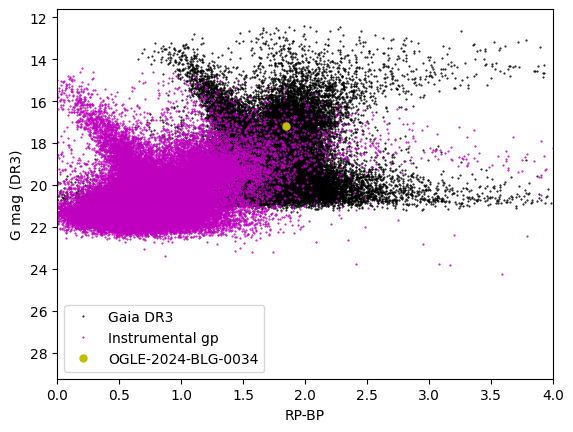

In [11]:
plt.plot(phot[:,6]-phot[:,8], phot[:,4], 'k.', markersize=1, label='Gaia DR3')
plt.plot(phot[:,0]-phot[:,2], phot[:,0], 'm.', markersize=1, label='Instrumental gp')

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([0, 4.0, ymax, ymin])
plt.xlabel('RP-BP')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,6]-phot[tselect,8], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034')
plt.legend()

plt.show()

A photometric calibration including colour terms has the form:

gp_cal = a0 + a1*gp_inst + a2*[(gp_inst - ip_inst)]

In [12]:
def phot_func(p,x):
    return p[0] + p[1]*x[0] + p[2]*x[1]

In [13]:
def calc_transform(pinit, x, y, bprp):
    linear_model = Model(phot_func)
    dataset = Data(np.vstack((x, bprp)), y)
    odr_obj = ODR(dataset, linear_model, beta0=pinit)
    results = odr_obj.run()

    pfit = np.array([results.beta[0], results.beta[1], results.beta[2]])
    covar_fit = results.cov_beta*results.res_var

    return pfit, covar_fit

In [14]:
x = phot[:,0] # Instrumental gp mags
y = phot[:,4] # G mag DR3
colours = (phot[:,0] - phot[:,2])  # Using instrumental colours from reference image
#colours = (phot[:,6] - phot[:,8]) # Using Gaia colours
phot_calib = [0.0, 0.0, 0.0]

(phot_calib, calib_covar) = calc_transform(phot_calib, x, y, colours)
print('Parameters of phot calibration with colour terms: ' + repr(phot_calib))

Parameters of phot calibration with colour terms: array([-3.10753061,  1.11818163, -1.1662224 ])


To sanity check this photometric calibration, we can re-plot the CMD above, applying the calibration to the instrumental photometry to convert it to Gaia DR3.

TARGET:  18.88855662668262 1.1272678698006757


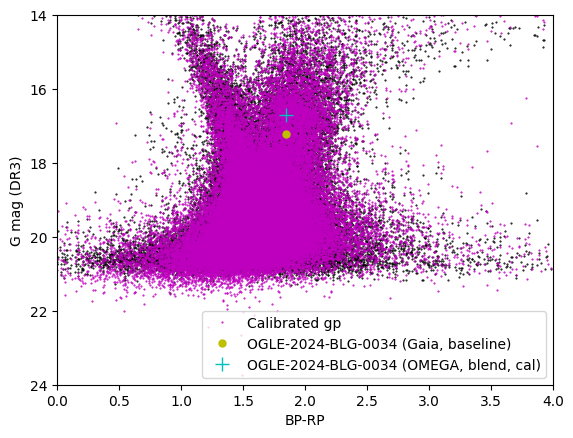

In [15]:
plt.plot(phot[:,6]-phot[:,8], phot[:,4], 'k.', markersize=1)

# Calibrate the instrumental gp data to G mag:
cal_gp = phot_func(phot_calib, np.vstack((phot[:,0],colours)))
plt.plot(phot[:,6]-phot[:,8], cal_gp, 'm.', markersize=1, label='Calibrated gp')

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([0, 4.0, 24.0, 14.0])
plt.xlabel('BP-RP')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,6]-phot[tselect,8], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034 (Gaia, baseline)')
plt.plot(phot[tselect,6]-phot[tselect,8], cal_gp[tselect], 'c+', markersize=10, label='OGLE-2024-BLG-0034 (OMEGA, blend, cal)')
plt.legend()
print('TARGET: ',phot[tselect,0], colours[tselect])
plt.show()

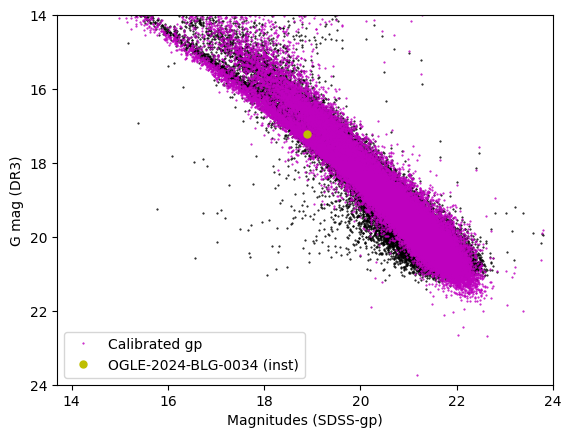

In [16]:
plt.plot(phot[:,0], phot[:,4], 'k.', markersize=1)
plt.plot(phot[:,0], cal_gp, 'm.', markersize=1, label='Calibrated gp')

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([xmin, 24.0, 24, 14])
plt.xlabel('Magnitudes (SDSS-gp)')
plt.ylabel('G mag (DR3)')

plt.plot(phot[tselect,0], phot[tselect,4], 'y.', markersize=10, label='OGLE-2024-BLG-0034 (inst)')
plt.legend()

plt.show()

So in conclusion: by transforming OMEGA's SDSS-band photometry to Gaia DR3 G-band and comparing with Gaia catalog data, we have confirmed that the OMEGA photometry is of good quality overall.  The next step is to calibrate the timeseries photometry.  This is a distinct calibration because previously we have derived a single calibration of SDSS-gp, ip -> Gaia G.  OMEGA obtains two-band lightcurves because they provide useful information about the time-dependent blending of the source as it is magnified during the event.  For this reason, it is useful to calibrate the two lightcurves independently in the SDSS passbands.  

## Calibrating the timeseries photometry data

As this target lies outside the central Bulge region, there are fewer photometric catalogs available to use as a calibration reference, and Gaia is really the best all-sky general reference available.  So the first step is to translate the Gaia reference catalog photometry into SDSS passbands using the published transformations.  

By default, the operational pipeline uses Gaia DR2 and [this set of transformations](https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html), but part of the process of generating multiband "field" data products is a crossmatch with Gaia DR3, so for our current analysis, we will use the [Gaia DR3 transformations](https://gea.esac.esa.int/archive/documentation/GDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html).  


In [17]:
# This code is a Gaia DR3 update of pyDANDIA's ggaia_phot_transforms.transform_gaia_phot_to_SDSS function

def transform_gaiadr3_phot_to_SDSS(Gmag, Gmerr, BPRPmag, BPRPerr):

    g_coeff = [0.2199, -0.6365, -0.1548, 0.0064]
    Gg_err = 0.0745
    r_coeff = [-0.09837, 0.08592, 0.1907, -0.1701, 0.02263]
    Gr_err = 0.03776
    i_coeff = [-0.293, 0.6404, -0.09609, -0.002104]
    Gi_err = 0.04092

    G_g = Gmag - (g_coeff[0] 
                  + g_coeff[1]*BPRPmag 
                  + g_coeff[2]*BPRPmag**2 
                  + g_coeff[3]*BPRPmag**3)
    g_err = np.sqrt( (Gmerr**2 
                    + g_coeff[1]**2)*BPRPerr**2 
                    + (4*g_coeff[2]**2*BPRPmag**2*BPRPerr**2) 
                    + (9*g_coeff[3]**2*BPRPmag**4*BPRPerr**2) 
                    + (Gg_err**2) )
    
    G_r = Gmag - (r_coeff[0] 
                  + r_coeff[1]*BPRPmag 
                  + r_coeff[2]*BPRPmag**2 
                  + r_coeff[3]*BPRPmag**3 
                  + r_coeff[4]*BPRPmag**4)
    r_err = np.sqrt( (Gmerr**2 
                    + r_coeff[1]**2)*BPRPerr**2 
                    + (4*r_coeff[2]**2*BPRPmag**2*BPRPerr**2) 
                    + (9*r_coeff[3]**2*BPRPmag**4*BPRPerr**2) 
                    + (16*r_coeff[4]**2*BPRPmag**4*BPRPerr**2) 
                    + (Gr_err**2) )
    
    G_i = Gmag - (i_coeff[0] 
                  + i_coeff[1]*BPRPmag 
                  + i_coeff[2]*BPRPmag**2
                  + i_coeff[3]*BPRPmag**3)
    i_err = np.sqrt( (Gmerr**2 
                    + i_coeff[1]**2)*BPRPerr**2 
                    + (4*i_coeff[2]**2*BPRPmag**2*BPRPerr**2) 
                    + (9*i_coeff[3]**2*BPRPmag**4*BPRPerr**2)
                    + (Gi_err**2) )

    phot = {}

    phot['g'] = Column(data=G_g, name='gmag')
    phot['g_err'] = Column(data=g_err, name='gmag_err')

    phot['r'] = Column(data=G_r, name='rmag')
    phot['r_err'] = Column(data=r_err, name='rmag_err')

    phot['i'] = Column(data=G_i, name='imag')
    phot['i_err'] = Column(data=i_err, name='imag_err')

    return phot

So let's transform the Gaia reference catalog to SDSS passbands

In [24]:
BPRPmag = phot[:,6] - phot[:,8]
BPRPerr = np.sqrt(phot[:,7]*phot[:,7] + phot[:,9]*phot[:,9])
phot_sdss = transform_gaiadr3_phot_to_SDSS(phot[:,4], phot[:,5], BPRPmag, BPRPerr)
gaia_phot_sdss = Table([Column(name='star_field_id', data=select_stars),
                        phot_sdss['g'], phot_sdss['g_err'], 
                        phot_sdss['r'], phot_sdss['r_err'],
                        phot_sdss['i'], phot_sdss['i_err']])
gaia_phot_sdss

star_field_id,gmag,gmag_err,rmag,rmag_err,imag,imag_err
int64,float64,float64,float64,float64,float64,float64
497,20.401101560068405,0.07840387148301736,19.3544835915932,0.054743573778718004,18.919150936074434,0.04636240635780695
526,19.575231807430438,0.10122603569451798,18.304757487782474,0.14597515362386457,17.719155887777813,0.07194862395950676
549,21.390132450742435,0.17579643045717733,20.316692857347533,0.2687748483947717,19.86533243763155,0.14730735318080576
552,19.721714714475144,0.07612550187292855,18.27945456105419,0.053708880529205374,17.546339786242935,0.04298235874127238
557,20.687758334366382,0.11065970980561944,19.528554923564933,0.1546780432752761,19.02258729063058,0.08267089960117388
558,19.517518233481077,0.07555234078286996,18.029032815449657,0.04954746095559504,17.250000376749153,0.04224188563013093
561,21.68068327024141,0.10530742600047048,20.223739039457005,0.18811287156879775,19.476357289343163,0.07463789833122707
562,20.565664885916725,0.09528793194663034,19.35293671679248,0.12122614498956401,18.81001087130846,0.06597185731062755
563,19.10885895896795,0.07560587339760777,17.594577138896813,0.05062481204666463,16.788593723458135,0.04229693700161795


TARGET:  star_field_id        gmag              gmag_err             rmag              rmag_err              imag             imag_err     
------------- ------------------ ------------------- ------------------ -------------------- ----------------- -------------------
        59600 18.643391368876944 0.07509545630021906 17.300725612799148 0.043150817487375426 16.65718703390376 0.04170631527767362


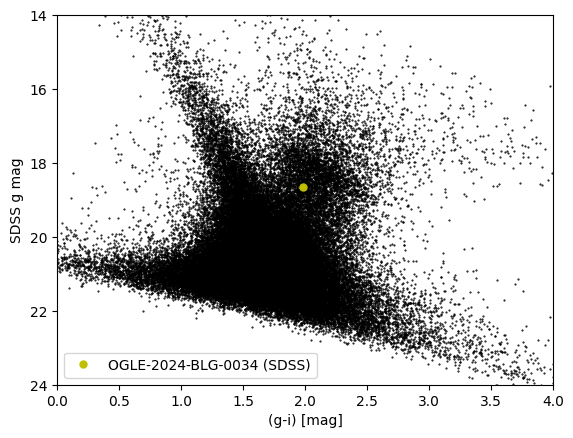

In [26]:
plt.plot(gaia_phot_sdss['gmag']-gaia_phot_sdss['imag'], gaia_phot_sdss['gmag'], 'k.', markersize=1)

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([0, 4.0, 24.0, 14.0])
plt.xlabel('(g-i) [mag]')
plt.ylabel('SDSS g mag')

plt.plot(gaia_phot_sdss['gmag'][tselect]-gaia_phot_sdss['imag'][tselect], 
         gaia_phot_sdss['gmag'][tselect], 
         'y.', markersize=10, label='OGLE-2024-BLG-0034 (SDSS)')
plt.legend()
print('TARGET: ',gaia_phot_sdss[tselect])
plt.show()

Now we can perform a similar fitting process as above, but derive the photometric calibration of the OMEGA photometry from the reference images in both passbands separately, using 3-parameter transforms of the form:

gp_cal = a0 + a1*gp_inst + a2*[(gp_inst - ip_inst)]

ip_cal = a0 + a1*ip_inst + a2*[(gp_inst - ip_inst)]

In [28]:
# OMEGA instrumental SDSS-gp -> Gaia calibrated SDSS-g
x = phot[:,0] # OMEGA Instrumental gp mags
y = gaia_phot_sdss['gmag'] # Gaia mag transformed to SDSS-g
colours = (phot[:,0] - phot[:,2])  # Using instrumental colours from reference image
gp_phot_calib = [0.0, 0.0, 0.0]

(gp_phot_calib, gp_calib_covar) = calc_transform(gp_phot_calib, x, y, colours)
print('Parameters of SDSS-g phot calibration with colour terms: ' + repr(gp_phot_calib))

# OMEGA instrumental SDSS-ip -> Gaia calibrated SDSS-i
x = phot[:,2] # OMEGA Instrumental ip mags
y = gaia_phot_sdss['imag']  # Gaia mag transformed to SDSS-i
ip_phot_calib = [0.0, 0.0, 0.0]

(ip_phot_calib, ip_calib_covar) = calc_transform(ip_phot_calib, x, y, colours)
print('Parameters of SDSS-i phot calibration with colour terms: ' + repr(ip_phot_calib))


Parameters of SDSS-g phot calibration with colour terms: array([-5.72945126,  1.25976177,  0.06735652])
Parameters of SDSS-i phot calibration with colour terms: array([-5.69257992,  1.20494077,  0.46895206])


Now we can use these transformations to calculate calibrated SDSS photometry for the stars in the OMEGA reference images in both bandpasses, and we can then plot the corresponding CMD and compare it with that of the Gaia data for this field.

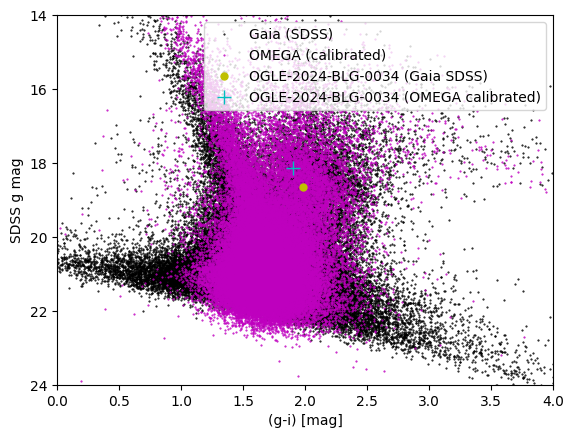

In [33]:
# Apply the calibrations to the OMEGA instrumental photometry
cal_gp = phot_func(gp_phot_calib, np.vstack((phot[:,0],colours)))
cal_ip = phot_func(ip_phot_calib, np.vstack((phot[:,2],colours)))
cal_gpip = cal_gp - cal_ip

# Plot OMEGA and Gaia(SDSS) CMDs for comparison
plt.plot(gaia_phot_sdss['gmag']-gaia_phot_sdss['imag'], gaia_phot_sdss['gmag'], 'k.', markersize=1, label='Gaia (SDSS)')
plt.plot(cal_gpip, cal_gp, 'm.', markersize=1, label='OMEGA (calibrated)')

[xmin,xmax, ymin, ymax] = plt.axis()
plt.axis([0, 4.0, 24.0, 14.0])
plt.xlabel('(g-i) [mag]')
plt.ylabel('SDSS g mag')

plt.plot(gaia_phot_sdss['gmag'][tselect]-gaia_phot_sdss['imag'][tselect], 
         gaia_phot_sdss['gmag'][tselect], 
         'y.', markersize=10, label='OGLE-2024-BLG-0034 (Gaia SDSS)')
plt.plot(cal_gpip[tselect], cal_gp[tselect], 'c+', markersize=10, label='OGLE-2024-BLG-0034 (OMEGA calibrated)')
plt.legend()
plt.show()

So the calibrations look sound.  Now we need to apply these two-band calibrations to the timeseries photometry, for which we need photometric uncertainties.  We can compute using the covarience matrices from the calibrations.  

In [34]:
def calc_calibrated_mags(fit_params, covar_fit, inst_mag, colours):
    """
    Function to calibrate instrumental magnitude and uncertainties using the precomputed photometric calibration parameters 
    and covarience matrix.  The inst_mag and colours arrays requires two columns for magnitude and uncertainity.
    """
    
    # Results array will be the same shape and indexing as the input photometry
    cal_mag = np.zeros(inst_mag.shape)

    # Apply the photometric calibration
    cal_mag[:,0] = phot_func(fit_params,np.vstack((inst_mag[:,0],colours[:,0])))
    
    # Calculate the uncertainties 
    ccalib = np.eye(5)
    ccalib[:3,:3] = covar_fit
    ccalib[3,3] = fit_params[0]**2
    ccalib[4,4] = fit_params[1]**2
    jac = np.c_[[1]*len(inst_mag), inst_mag[:,0], colours[:,0], inst_mag[:,1], colours[:,1]]
    errors = []
    for i in range(len(jac)):
        vect = []
        for j in range(len(ccalib)):
            vect.append(np.sum(ccalib[j]*jac[i]))
        errors.append(np.sum(vect*jac[i])**0.5)
    cal_mag[:,1] = errors

    # Mask values likely to be out of bound
    idx = np.where(phot[:,0] < 7.0)
    cal_mag[idx,0] = 0.0
    cal_mag[idx,1] = 0.0

    return cal_mag

Load the instrumental timeseries photometry produced by the pipeline

In [35]:
def load_extn_lc(file_path):
    """
    Function to load the full set of columns from a pyDANDIA lightcurve file in .dat format

    This includes columns:
    # HJD    Instrumental mag, mag_error   Calibrated mag, mag_error    Corrected mag, mag_error  QC Flag    Image
    """

    if not path.isfile(file_path):
        raise IOError(file_path + ' not found')

    data = []
    images = []
    line_list = open(file_path, 'r').readlines()
    for line in line_list:
        if '#' not in line:
            entries = line.replace('\n', '').split()
            datum = [float(entries[i]) for i in range(0,8,1)]
            data.append(datum)
            images.append(entries[8])
    data = np.array(data)

    float_cols = ['HJD', 'Instrumental mag', 'Inst_mag_error', 'Calibrated mag', 'Cal_mag_error', 'Corrected mag', 'Corr_mag_error', 'QC Flag']
    column_list = [Column(name=float_cols[i], data=data[:,i]) for i in range(0,8,1)]
    column_list.append(Column(name='Image', data=images))
    
    return Table(column_list)


In [36]:
gp_lc = load_extn_lc(gp_lc_file)
ip_lc = load_extn_lc(ip_lc_file)

Now we can use the calibration and functions above to calculate revised calibrated magnitudes, and output the updated lightcurves. 

In [37]:
# SDSS-gp lightcurve
gp_phot = np.c_[(gp_lc['Instrumental mag'].data,gp_lc['Inst_mag_error'].data)]
colours = np.zeros(gp_phot.shape)
colours[:,0] = np.array([phot[tselect,0] - phot[tselect,2]]*len(gp_phot)) # Target colour in reference image used for all images
sig_col = np.sqrt(phot[tselect,1]*phot[tselect,1] + phot[tselect,3]*phot[tselect,3])
colours[:,1] = np.array([sig_col]*len(gp_phot))
gp_phot = calc_calibrated_mags(gp_phot_calib, gp_calib_covar, gp_phot, colours)

# SDSS-ip lightcurve
ip_phot = np.c_[(ip_lc['Instrumental mag'].data,ip_lc['Inst_mag_error'].data)]
colours = np.zeros(ip_phot.shape)
colours[:,0] = np.array([phot[tselect,0] - phot[tselect,2]]*len(ip_phot)) # Target colour in reference image used for all images
sig_col = np.sqrt(phot[tselect,1]*phot[tselect,1] + phot[tselect,3]*phot[tselect,3])
colours[:,1] = np.array([sig_col]*len(ip_phot))
ip_phot = calc_calibrated_mags(ip_phot_calib, ip_calib_covar, ip_phot, colours)

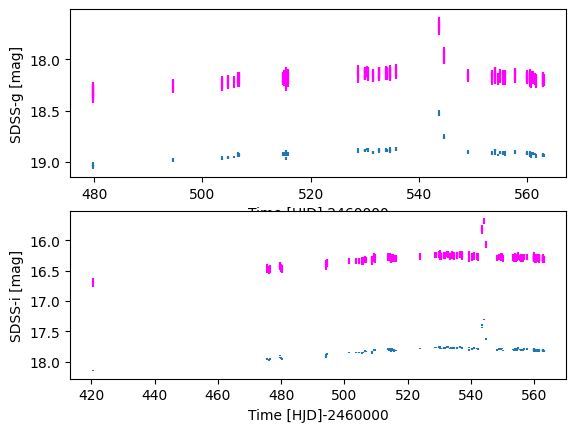

In [39]:
fig, axs = plt.subplots(2,1)

# Gp- lightcurve
axs[0].errorbar(
    gp_lc['HJD']-2460000.0, 
    gp_lc['Instrumental mag'], 
    yerr=gp_lc['Inst_mag_error'], 
    marker='.', mfc='k', markersize=1, fmt='none',
    label='Instrumental'
)
axs[0].errorbar(
    gp_lc['HJD']-2460000.0, 
    gp_phot[:,0], 
    yerr=gp_phot[:,1], 
    marker='.', markersize=1, 
    color='magenta',
    fmt='none', 
    label='Calibrated'
)

axs[0].set_xlabel('Time [HJD]-2460000')
axs[0].set_ylabel('SDSS-g [mag]')

[xmin, xmax, ymin, ymax] = axs[0].axis()
axs[0].axis([xmin, xmax, ymax, ymin])
#axs[0].legend()

# Ip - lightcurve
axs[1].errorbar(
    ip_lc['HJD']-2460000.0, 
    ip_lc['Instrumental mag'], 
    yerr=ip_lc['Inst_mag_error'], 
    marker='.', mfc='k', markersize=1, fmt='none',
    label='Instrumental'
)
axs[1].errorbar(
    ip_lc['HJD']-2460000.0, 
    ip_phot[:,0], 
    yerr=ip_phot[:,1], 
    marker='.', markersize=1, 
    color='magenta',
    fmt='none', 
    label='Calibrated'
)

axs[1].set_xlabel('Time [HJD]-2460000')
axs[1].set_ylabel('SDSS-i [mag]')

[xmin, xmax, ymin, ymax] = axs[1].axis()
axs[1].axis([xmin, xmax, ymax, ymin])
#axs[1].legend()

plt.show()

So lastly we can replace the lightcurve's orginal calibrated magnitude and uncertainty columns with the newly calibrated data, and output to file.

In [40]:
def output_lc(lc_table, file_path):

    with open(file_path, 'w') as f:
        f.write('# HJD    Instrumental mag, mag_error   Calibrated mag, mag_error    Corrected mag, mag_error  QC Flag    Image\n')
        for i in range(0,len(lc_table),1):
            f.write(str(lc_table['HJD'][i]) + ' ' 
                    + str(lc_table['Instrumental mag'][i]) + ' '
                    + str(lc_table['Inst_mag_error'][i]) + ' '
                    + str(lc_table['Calibrated mag'][i]) + ' ' 
                    + str(lc_table['Cal_mag_error'][i]) + ' ' 
                    + str(lc_table['Corrected mag'][i]) + ' ' 
                    + str(lc_table['Corr_mag_error'][i]) + ' ' 
                    + str(lc_table['QC Flag'][i]) + ' ' 
                    + lc_table['Image'][i] + '\n')
        f.close()


In [41]:
gp_lc['Calibrated mag'] = gp_phot[:,0]
gp_lc['Cal_mag_error'] = gp_phot[:,1]

lc_file_new = gp_lc_file.replace('.dat', '_new.dat')
output_lc(gp_lc, lc_file_new)

ip_lc['Calibrated mag'] = ip_phot[:,0] 
ip_lc['Cal_mag_error'] = ip_phot[:,1] 

lc_file_new = ip_lc_file.replace('.dat', '_new.dat')
output_lc(ip_lc, lc_file_new)

We also need to output the photometric calibration details

In [42]:
file_path = path.join(path.dirname(xmatch_file_path), 'phot_calibration.json')
calib = {
    'g': {
        'a0': gp_phot_calib[0],
        'a1': gp_phot_calib[1],
        'a2': gp_phot_calib[2],
        'covar': gp_calib_covar.tolist()
    }, 
    'i': {
        'a0': ip_phot_calib[0],
        'a1': ip_phot_calib[1],
        'a2': ip_phot_calib[2],
        'covar': ip_calib_covar.tolist()
    }, 
}
with open(file_path, "w") as f:
    json.dump(calib, f, indent=4)


Output the calibrated CMD data to file

In [47]:
# Calculate the calibrated magnitude and uncertainty for all stars in the reference image
gp_phot = np.c_[(phot[:,0], phot[:,1])]
colours = np.zeros(gp_phot.shape)
colours[:,0] = np.array([phot[:,0] - phot[:,2]])
sig_col = np.sqrt(phot[:,1]*phot[:,1] + phot[:,3]*phot[:,3])
colours[:,1] = np.array([sig_col])
gp_phot = calc_calibrated_mags(gp_phot_calib, gp_calib_covar, gp_phot, colours)

ip_phot = np.c_[(phot[:,2], phot[:,3])]
ip_phot = calc_calibrated_mags(ip_phot_calib, ip_calib_covar, ip_phot, colours)

cal_colours = np.zeros(gp_phot.shape)
cal_colours[:,0] = gp_phot[:,0] - ip_phot[:,0]
cal_colours[:,1] = np.sqrt(gp_phot[:,1]*gp_phot[:,1] 
                           + ip_phot[:,1]*ip_phot[:,1])

file_path = path.join(path.dirname(xmatch_file_path), target_name+'_omega_cal_cmd.dat')
with open(file_path, 'w') as f:
    f.write('# Colour-magnitude Data for OMEGA-II observations of ' + target_name + '\n')
    f.write('# Calibrated to Gaia DR3 Gmag and BP-RP colours\n')
    f.write('# Target ' + target_name + ' has star_field_id=' + str(target_field_id) + '\n')
    f.write('#\n')
    f.write('# star_field_ID  SDSS-g  g_mag_error [mag] SDSS-i i_mag_error [mag]  BP-RP BP-RP error [mag]\n')
    for j in range(0,len(gp_phot),1):
        f.write(
            str(select_stars[j]+1) + '  ' 
            + str(gp_phot[j,0]) + '  ' 
            + str(gp_phot[j,1]) + '  '
            + str(ip_phot[j,0]) + '  ' 
            + str(ip_phot[j,1]) + '  '
            + str(cal_colours[j,0]) + '  ' 
            + str(cal_colours[j,1]) + '\n')
    f.close()